#### 부록: 선행 데이터셋, 함수

In [1]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02):

  # 마커와 컬러맵 설정
  markers = ('s', 'x', 'o', '^', 'v') # 사각형, 곱셈 기호, 원, 삼각형, 뒤집힌 삼각형
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))]) # unique: numpy함수로, 고유값 반환

  # 결정 경계(Decision Boundary) 그리기
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), \
                          np.arange(x2_min, x2_max, resolution))

  Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T) 
  #ravel: 1차원으로 만들어주는 numpy 함수
  Z = Z.reshape(xx1.shape)

  plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap) 
  #contourf: python함수, 2차원 등고선 플롯/ alpha: 투명도/ cmap: Colormap, 레벨 값을 색에 매핑 
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  #산점도 그리기
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0],y=X[y == cl, 1], alpha=0.8, c=colors[idx], \
      marker=markers[idx],label=cl, edgecolor = 'black')

  #테스트 샘플 부각
  if test_idx:
    X_test, y_test = X[test_idx, :], y[test_idx]
    plt.scatter(X_test[:, 0],X_test[:, 1], alpha=1.0, c='None', marker='o', \
      label='test set',linewidth = 1, s = 100, edgecolor = 'black')

iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std)) #vertical stack
y_combined = np.hstack((y_train, y_test)) #horizontal stack

### 3-2. 로지스틱 회귀(Logistic Regression)

---

로지스틱 회귀는 선형적으로 구분되는 클래스에 뛰어난 성능을 내는 분류 모델  

이진 분류를 위한 선형 모델이지만 다중 분류로 확장 가능<br/><br/>    
  
* 로지스틱 시그모이드 함수  

  Odds는 특정 이벤트가 발생할 확률이다. 이를 비율로 취한 Odds Ratio = $P \over (1-P)$  

  오즈비에 log를 취해 logit함수를 정의한다.

  $$\mathit{logit} (P) = log {P \over (1 - P)}$$

  특성의 가중치 합과 로그 오즈 사이의 선형 관계를 다음과 같이 쓸 수 있다.

  $$\mathit{logit} (P(y = 1 | x)) = \sum_{i=0}^m w_ix_i = \boldsymbol{w}^T\boldsymbol{x}$$

  z가 주어졌을 때 P를 예측하는 것이 목적이므로, 역함수를 취한다.

  $$log {P \over (1 - P)} = \boldsymbol{w}^T\boldsymbol{x} = z,\quad {P \over (1 - P)} = e^z,\quad P = {1 \over {1+e^{-z}}}$$
  
  따라서 **로지스틱 시그모이드 함수**(logistic sigmoid function)

  $$\phi(z) = {1\over {1+e^{-z}}}, \quad z = \boldsymbol{w}^T\boldsymbol{x}$$

  sigmoid function을 그려 보자.

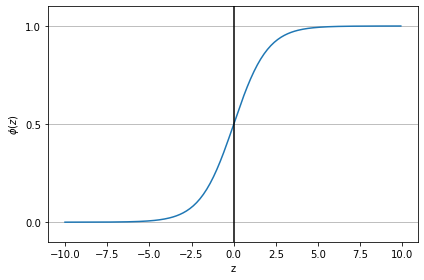

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-10,10,0.1)
phi_z = sigmoid(z)
plt.plot(z,phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi(z)$')
plt.yticks([0.0,0.5,1.0]) # 격자선
ax = plt.gca() # 현재 ax개체 반환
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

$z \rightarrow \infty$ : $\phi(z) \rightarrow 1$  

$z \rightarrow -\infty$ : $\phi(z) \rightarrow 0$

시그모이드 함수는 실수 입력값을 [0,1]사이 값으로 반환하고, 중간은 $\phi(0)=0.5$이다.  

$\phi(z) = 0.6$ 이라면 이 샘플은 클래스 1일 확률이 60%이다.  

임계 함수를 이용해 예측 확률을 이진 출력으로 바꿀 수 있다.

$$\hat{y} = \begin{cases} 1 & \phi(z) \ge 0.5 \ \ (z \ge 0.0) \\ 0 & else \end{cases}$$

클래스 레이블을 예측하는 것 외에 클래스에 소속될 확률을 추정하는 것이 유용할 경우 강력<br/><br/>  


* 로지스틱 회귀모델의 손실 함수

  Ch2에서 배운 퍼셉트론과 아달린에서, 비용 함수로 MSE(Mean Squared Error)를 사용하였다.  

  그러나 로지스틱 회귀에서는 MSE를 비용 함수로 사용할 수 없다.  

  <img src="3-2_image/lr_mse.png" width="60%" height="60%" title="Logistic Regression Cost Function"></img>

  평야가 많아 Gradient Descent 알고리즘이 제대로 동작하지 않는다.(non-convex)  

  따라서 다른 비용함수를 정의해야 한다.  

  이를 위해 로그 가능도 함수(Log-Likelihood Function)을 사용한다.  
  가능도(우도)함수에 대해서는 추후 포스팅을 통해 상세하게 설명하겠다.  

  $$l(\boldsymbol{w}) = \sum_{i=1}^n \left[{ y^{(i)}log(\phi(z^{(i)}))+(1-y^{(i)})log(1-\phi(z^{(i)}))} \right]$$

  부호를 반대로 하면 비용함수 $J$를 정의할 수 있다.  
  이 함수는 Convex하고, 잘못된 예측에 큰 비용을 부과한다.

  $$J(\boldsymbol{w}) = \sum_{i=1}^n \left[{ -y^{(i)}log(\phi(z^{(i)}))-(1-y^{(i)})log(1-\phi(z^{(i)}))} \right]$$

  샘플이 하나일 때 비용을 계산해보자.  
  $y=0$일 때 첫 항이 0이,  $y=1$일 때 둘째 항이 0이 된다.

  $$J(\phi(z),y;\boldsymbol{w}) = \begin{cases} -log(\phi(z)) & y=1 \\ -log(1-\phi(z)) & y=0 \end{cases}$$

  이를 도시화해보자.  

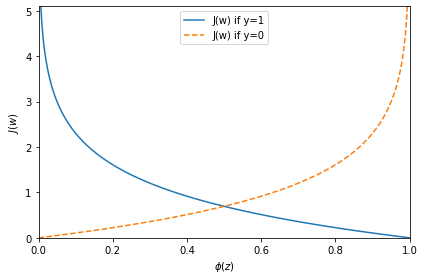

In [3]:
def cost_1(z):
  return -np.log(sigmoid(z))
def cost_0(z):
  return -np.log(1 - sigmoid(z))

z = np.arange(-10,10,0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c1, label = 'J(w) if y=1')  
plt.plot(phi_z, c0, label = 'J(w) if y=0', linestyle = '--')  
plt.xlabel('$\phi(z)$')
plt.ylabel('$J(w)$')
plt.xlim([0,1])
plt.ylim(0.0,5.1)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

  잘못된 예측에 점점 큰 비용을 부과하는 것을 알 수 있다.<br/><br/>  

  * 로지스틱 회귀 구현

로지스틱 회귀를 구현해 보자. 2-2 아달린 구현에서 비용함수 J를 로지스틱 회귀에 맞게 바꾸면 된다.

In [4]:
import numpy as np

class LogisticRegressionGD(object):
  """적응형 선형 뉴런 분류기

  매개변수
  ------------
  eta : float
    learning rate(0.0 ~ 1.0)

  n_iter : int
    훈련 데이터셋 반복 횟수

  random_state : int
    가중치 무작위 초기화를 위한 난수 생성기 시드


  속성
  ------------
  w_ : 1d-array
    학습된 가중치

  cost_ : list
    epoch마다 누적된 비용 함수의 제곱합

  """
  def __init__(self, eta=0.05, n_iter=100, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self,X,y):
    """훈련 데이터 학습

    매개변수
    ------------
    X : {array-like}, shape = [n_samples, n_features]
     n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
    
    y : array-like, shape = [n_samples]
     타깃 값

    반환 값
    ------------
    self : object

    """
    rgen = np.random.RandomState(seed = self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
    self.cost_ = []

    for i in range(self.n_iter):
      net_input = self.net_input(X)
      output = self.activation(net_input)
      errors = (y - output)
      self.w_[1:] += self.eta * X.T.dot(errors)
      self.w_[0] += self.eta * errors.sum()
      #Logistic Regression Cost Function
      cost = (-y.dot(np.log(output)) - (1 - y).dot(np.log(1 - output)))
      self.cost_.append(cost)

    return self

  def net_input(self, X):
    """최종 입력 계산"""
    return np.dot(X, self.w_[1:]) + self.w_[0]

  def activation(self ,z):
    """로지스틱 시그모이드 활성화 계산"""
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
  def predict(self, X):
    """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
    return np.where(self.net_input(X) >= 0.0, 1, 0)

붓꽃 데이터셋을 이용해 이진 분류 문제에 대한 로지스틱 회귀 구현을 도시화한다.<br/>  

/var/folders/93/wz9d35t12bggw18wk6g_80j80000gn/T/ipykernel_26087/3346279272.py:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],y=X[y == cl, 1], alpha=0.8, c=colors[idx], \


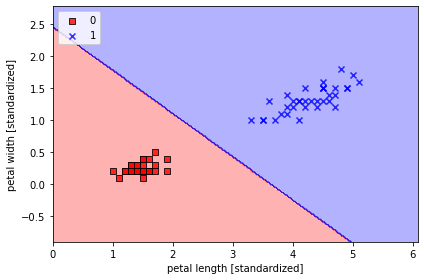

In [5]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta = 0.05, n_iter = 1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(X = X_train_01_subset, y = y_train_01_subset, classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

* 사이킷런을 사용해 로지스틱 회귀 모델 훈련

사이킷런에서 로지스틱 회귀를 사용하는 법을 알아보자.  

sklearn.linear_model.LogisticRegression의 fit메서드를 사용하여 표준화 처리된 붓꽃 데이터셋의 클래스 3개를 대상으로 훈련한다.

/var/folders/93/wz9d35t12bggw18wk6g_80j80000gn/T/ipykernel_26087/3346279272.py:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],y=X[y == cl, 1], alpha=0.8, c=colors[idx], \


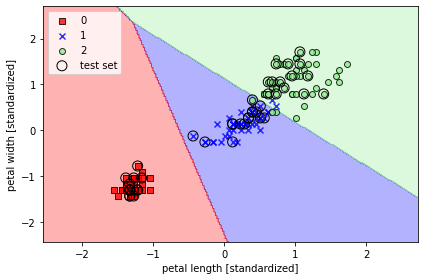

In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear', multi_class='auto', C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx = range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

`C` : 매개변수, 규제  

predict_proba 메서드를 사용해 샘플이 어떤 클래스에 속할 지 계산  
사이킷런은 입력 데이터로 2차원 배열을 지원하므로 2차원 포맷으로 변경해야 한다.(ex: reshape)

In [7]:
print("각 클래스 소속 확률:")
print(lr.predict_proba(X_test_std[:3,:]))
print("클래스 레이블:")
print(lr.predict_proba(X_test_std[:3,:]).argmax(axis=1))
#print(lr.predict(X_test_std[:3,:]))
lr.predict(X_test_std[0,:].reshape(1,-1))

각 클래스 소속 확률:
[[3.17983737e-08 1.44886616e-01 8.55113353e-01]
 [8.33962295e-01 1.66037705e-01 4.55557009e-12]
 [8.48762934e-01 1.51237066e-01 4.63166788e-13]]
클래스 레이블:
[2 0 0]


array([2])

* 규제(regularization)

    편향(bias): 예측값이 정확한 값에서 얼마나 벗어났는가  $\left(E[\hat{f}(x)]-f(x)\right)^2$

    분산(variance): 예측값들끼리 얼마나 흩어져있는가 $E[(\hat{f}(x)-E[\hat{f}(x)])^2]$

    과대적합(overfitting) : 낮은 편향, 높은 분산  

    과소적합(underfitting) : 높은 편향, 낮은 분산  

    <img src="3-2_image/overunderfitting.png" width="60%" height="60%" title="Overfitting, UnderFitting"></img>  

    규제는 가중치를 제한하여 과대적합을 방지할 수 있는 유용한 방법이다.  

    가중치를 제한하기 위해 추가적인 정보(편향)을 주입한다.  

    모든 특성이 비슷한 스케일을 가져야 하므로, 특성 스케일 조정이 중요하다.  

    다음과 같은 L2규제를 널리 쓴다. $\lambda$는 규제 하이퍼파라미터이다.  

    $${\lambda \over 2}\lVert\boldsymbol{w}\rVert^2 = {\lambda \over 2}\sum_{j=1}^m w_j^2$$

    Logistic regression의 cost function에 규제항을 추가한다.  

    $$J(\boldsymbol{w}) = \sum_{i=1}^n \left[{ -y^{(i)}log(\phi(z^{(i)}))-(1-y^{(i)})log(1-\phi(z^{(i)}))} \right] + {\lambda \over 2}\lVert\boldsymbol{w}\rVert^2$$

    사이킷런 LogisticRegression 클래스의 매개변수 C는 $\lambda$의 역수로, C를 감소시키면 규제 강도가 증가한다.  

    2개의 가중치에 대해 L2 규제 효과를 그래프로 도시해보자.

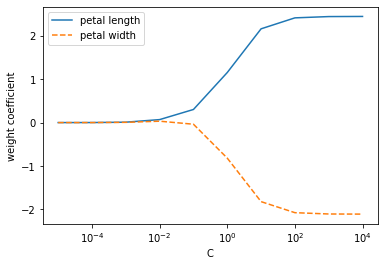

In [8]:
weights, params = [], []

for c in np.arange(-5,5):
    lr = LogisticRegression(solver='liblinear', multi_class='auto', C=10.**c, random_state = 1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:,0], label = 'petal length')
plt.plot(params, weights[:,1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient') # coefficient: 계수
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

매개변수 C가 감소하면 가중치 절댓값이 줄어드는, 즉 규제 강도가 증가하는 것을 확인할 수 있다.